# Differential expression analysis
In this notebook we'll use `PyDESeq2` to perform differential expression analysis on the RNAseq data. We're going to follow [this tutorial](https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_minimal_pydeseq2_pipeline.html).

In [77]:
from os import listdir
import pandas as pd
import numpy as np
from functools import reduce
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Data pre-processing
Read in counts matrices:

In [55]:
kallisto_output_dir = '../data/kallisto_quant_bs'
abundance_dfs = {}
for d in listdir(kallisto_output_dir):
    abundance_dfs[d] = pd.read_csv(f'{kallisto_output_dir}/{d}/abundance.tsv', sep='\t')

Merge counts matrices into the format expected by DESeq2:

In [69]:
counts_df = reduce(lambda x, y: pd.merge(x, y, on='target_id'), [df[['target_id', 'est_counts']].rename(columns={'est_counts': k}) for k, df in abundance_dfs.items()]).set_index('target_id').T
counts_df = counts_df.astype('int')
counts_df.head()

target_id,ATCG00020.1,ATCG00040.1,ATCG00050.1,ATCG00065.1,ATCG00070.1,ATCG00080.1,ATCG00120.1,ATCG00130.1,ATCG00140.1,ATCG00150.1,...,AT5G67570.1,AT5G67580.2,AT5G67580.1,AT5G67590.1,AT5G67600.1,AT5G67610.2,AT5G67610.1,AT5G67620.1,AT5G67630.1,AT5G67640.1
7h_21o2_c,3922560,276029,3511,1579,57120,30897,199521,120238,42012,118059,...,79,0,87,397,91,96,0,0,216,39
1h_40o2_b,3155200,280744,3113,1056,54298,88869,231346,180709,52211,99181,...,22,51,0,259,163,45,0,0,133,77
1h_40o2_d,2216700,203774,1776,519,37009,60297,179582,133117,46929,70819,...,11,0,46,197,100,21,0,0,102,43
7h_2o2_b,2838350,220852,3799,1058,41754,57818,175781,118734,56243,82193,...,57,0,79,370,106,68,0,3,267,37
7h_2o2_a,3185190,208893,4244,979,48506,73996,162560,124174,67164,84278,...,75,88,0,442,182,116,0,0,270,27


In order to use DESeq2, we need to create a metadata dataframe to accompany our counts matrix:

In [70]:
metadata = pd.DataFrame({'condition': counts_df.index.str.split('_').str[1], 'group':counts_df.index.str.split('_').str[0]}, index=counts_df.index)
metadata.head()

,condition,group
7h_21o2_c,21o2,7h
1h_40o2_b,40o2,1h
1h_40o2_d,40o2,1h
7h_2o2_b,2o2,7h
7h_2o2_a,2o2,7h


Filter the data to remove missing or lowly expressed genes:

In [71]:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 30] # Taken from Larry's analysis
counts_df = counts_df[genes_to_keep]

In [72]:
counts_df.shape

(24, 35690)

## Modeling

In [73]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    inference=inference,
)

In [74]:
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 41.85 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 48.91 seconds.

Fitting LFCs...
... done in 33.55 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 1890 outlier genes.

Fitting dispersions...
... done in 1.32 seconds.

Fitting MAP dispersions...
... done in 1.11 seconds.

Fitting LFCs...
... done in 1.89 seconds.



## PCA

Reproducing the following plot:

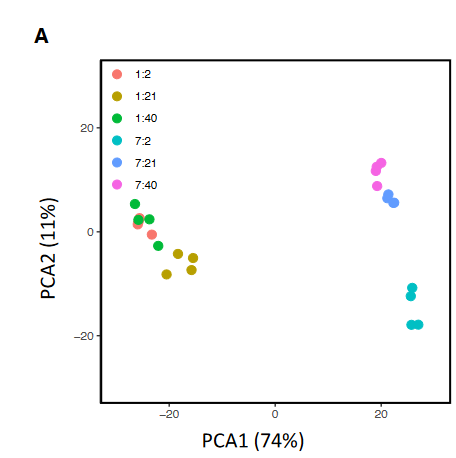

We'll use a variance stablizing transformation before we run the PCA, because that's what it looks like Larry did.

In [75]:
dds.vst()

Fit type used for VST : parametric


Fitting dispersions...
... done in 41.00 seconds.

/mnt/home/lotrecks/.conda/envs/omics/lib/python3.9/site-packages/anndata/_core/views.py:145: RuntimeWarning: divide by zero encountered in divide
  results = super().__array_ufunc__(


In [79]:
dds.layers["vst_counts"].shape

(24, 35690)

In [84]:
X = dds.layers["vst_counts"]
y = counts_df.index.str.split('_').str[:2].str.join('_')

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

{'1h_2o2': array([0.12156863, 0.46666667, 0.70588235, 1.        ]), '7h_2o2': array([0.17254902, 0.62745098, 0.17254902, 1.        ]), '1h_21o2': array([0.58039216, 0.40392157, 0.74117647, 1.        ]), '7h_40o2': array([0.89019608, 0.46666667, 0.76078431, 1.        ]), '7h_21o2': array([0.7372549 , 0.74117647, 0.13333333, 1.        ]), '1h_40o2': array([0.61960784, 0.85490196, 0.89803922, 1.        ])}


<Figure size 640x480 with 0 Axes>

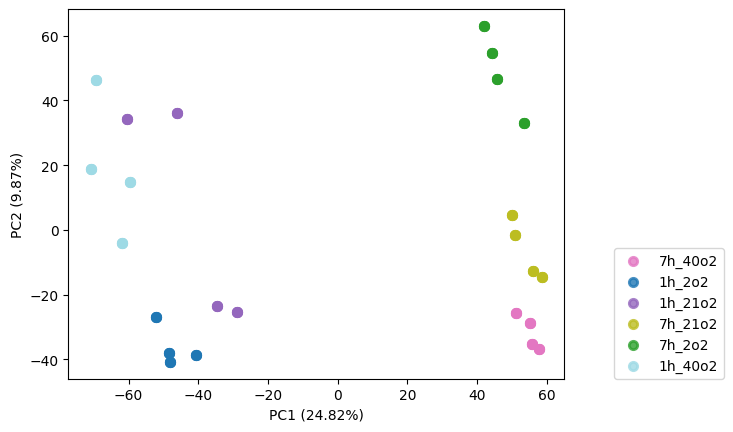

In [85]:
plt.figure()
colors = {i: c for i, c in zip(set(y), plt.cm.tab20(np.linspace(0, 1, len(set(y)))))}
print(colors)
pc1_ex_var, pc2_ex_var = pca.explained_variance_ratio_
lw = 2

fig, ax = plt.subplots(1)
for i in y:
    ax.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=colors[i], alpha=0.8, lw=lw, label=i
    )
ax.set_xlabel(f'PC1 ({pc1_ex_var*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pc2_ex_var*100:.2f}%)')

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles[::-1], labels[::-1])) if l not in labels[::-1][:i]]
    ax.legend(*zip(*unique), loc=(1.1,0))
legend_without_duplicate_labels(ax)

The explained variance is vastly different than in the plot we're trying to reproduce, however, very encouragingly we see the similar trends in separation! At least we do in the fact that PC1 explains the variance between timepoints, and that the 1 hour samples are not very different from one another.

## DE statistical analysis

For the moment, we're going to filter out the 1h timepoints in the interest of reproducing Kaila's original analysis; we can come back and do 1h vs 7h per condition later on if we're interested in doing so. We then need to re-run the modeling component again before doing the statistical analysis:

In [86]:
samples_to_keep = metadata[metadata['group'] == '7h'].index
metadata = metadata.loc[samples_to_keep]
counts_df = counts_df.loc[samples_to_keep]
print(metadata.shape, counts_df.shape)

(12, 2) (12, 35690)


In [87]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    inference=inference,
)
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.34 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 42.82 seconds.

Fitting LFCs...
... done in 31.48 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [88]:
ds_2_vs_21 = DeseqStats(
    dds,
    contrast=['condition', '2o2', '21o2'],
    alpha=0.05
)

In [89]:
ds_2_vs_21.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition 2o2 vs 21o2
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
target_id                                                                 
ATCG00020.1  3.501801e+06       -0.295507  0.077927 -3.792088  0.000149   
ATCG00040.1  2.633802e+05       -0.503968  0.117509 -4.288746  0.000018   
ATCG00050.1  3.837515e+03        0.105851  0.129142  0.819648  0.412417   
ATCG00065.1  1.433805e+03       -0.257827  0.182547 -1.412389  0.157836   
ATCG00070.1  5.179731e+04       -0.151372  0.127535 -1.186905  0.235265   
...                   ...             ...       ...       ...       ...   
AT5G67600.1  1.098525e+02        0.425098  0.223944  1.898233  0.057665   
AT5G67610.2  7.521073e+01        0.346299  0.754286  0.459108  0.646156   
AT5G67610.1  1.551466e+01       -6.818066  3.919580 -1.739489  0.081949   
AT5G67630.1  1.934955e+02        0.064850  0.156580  0.414162  0.678756   
AT5G67640.1  4.177491e+01       -0.22683

... done in 182.59 seconds.



In [90]:
DE_2_vs_21 = ds_2_vs_21.results_df
DE_2_vs_21.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
target_id,,,,,,
ATCG00020.1,3.501801e+06,-0.295507,0.077927,-3.792088,0.000149,0.002128
ATCG00040.1,2.633802e+05,-0.503968,0.117509,-4.288746,0.000018,0.000338
ATCG00050.1,3.837515e+03,0.105851,0.129142,0.819648,0.412417,0.758740
ATCG00065.1,1.433805e+03,-0.257827,0.182547,-1.412389,0.157836,0.448369
ATCG00070.1,5.179731e+04,-0.151372,0.127535,-1.186905,0.235265,0.567768


In [91]:
ds_40_vs_21 = DeseqStats(
    dds,
    contrast=['condition', '40o2', '21o2'],
    alpha=0.05
)

In [92]:
ds_40_vs_21.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition 40o2 vs 21o2
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
target_id                                                                 
ATCG00020.1  3.501801e+06       -0.049070  0.077927 -0.629688  0.528899   
ATCG00040.1  2.633802e+05       -0.160453  0.117508 -1.365455  0.172110   
ATCG00050.1  3.837515e+03       -0.020258  0.129238 -0.156749  0.875442   
ATCG00065.1  1.433805e+03        0.241795  0.182337  1.326091  0.184810   
ATCG00070.1  5.179731e+04        0.030226  0.127535  0.237002  0.812655   
...                   ...             ...       ...       ...       ...   
AT5G67600.1  1.098525e+02        0.191430  0.226443  0.845380  0.397899   
AT5G67610.2  7.521073e+01       -0.066512  0.755923 -0.087988  0.929886   
AT5G67610.1  1.551466e+01        0.723894  3.541092  0.204427  0.838020   
AT5G67630.1  1.934955e+02       -0.365108  0.159939 -2.282797  0.022442   
AT5G67640.1  4.177491e+01        0.4590

... done in 7.45 seconds.



In [93]:
DE_40_vs_21 = ds_40_vs_21.results_df
DE_40_vs_21.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
target_id,,,,,,
ATCG00020.1,3.501801e+06,-0.049070,0.077927,-0.629688,0.528899,0.919549
ATCG00040.1,2.633802e+05,-0.160453,0.117508,-1.365455,0.172110,0.647614
ATCG00050.1,3.837515e+03,-0.020258,0.129238,-0.156749,0.875442,0.989188
ATCG00065.1,1.433805e+03,0.241795,0.182337,1.326091,0.184810,0.665537
ATCG00070.1,5.179731e+04,0.030226,0.127535,0.237002,0.812655,0.981206


## Number of DE genes at conditions

Reproducing the following plot (all samples are from 7h):

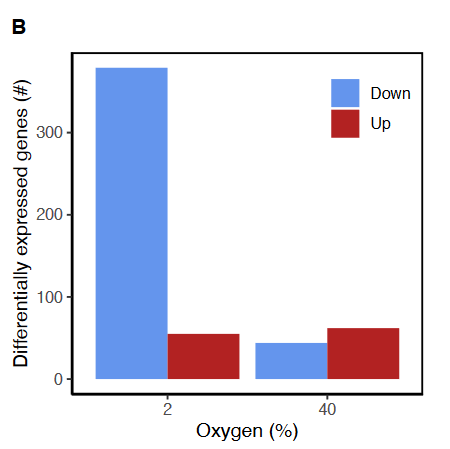

In [94]:
two_up = DE_2_vs_21[(DE_2_vs_21["padj"] < 0.05) & (DE_2_vs_21["log2FoldChange"] > 0)]
two_down = DE_2_vs_21[(DE_2_vs_21["padj"] < 0.05) & (DE_2_vs_21["log2FoldChange"] < 0)]
forty_up = DE_40_vs_21[(DE_2_vs_21["padj"] < 0.05) & (DE_40_vs_21["log2FoldChange"] > 0)]
forty_down = DE_40_vs_21[(DE_2_vs_21["padj"] < 0.05) & (DE_40_vs_21["log2FoldChange"] < 0)]

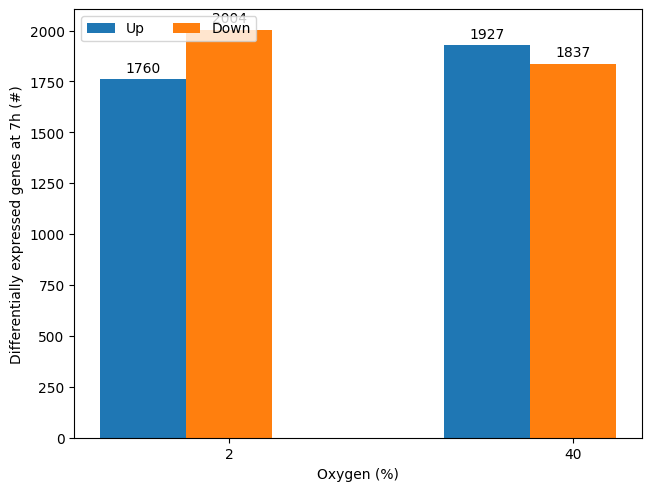

In [99]:
conditions = ('2', '40')
values = {
    'Up': (len(two_up), len(forty_up)),
    'Down': (len(two_down), len(forty_down))
}

x = np.arange(len(conditions))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
ax.set_ylabel('Differentially expressed genes at 7h (#)')
ax.set_xlabel('Oxygen (%)')
ax.set_xticks(x + width, conditions)
ax.legend(loc='upper left', ncols=3)

Well that is very different, but to a level that makes me think I probably did something obvious wrong, although I'm not sure what that might be.